In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [1]:
!pip install --quiet scikit-learn==1.4.2 joblib matplotlib seaborn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 112.1 MB/s eta 0:00:00


In [3]:
ZIP_PATH = "/content/drive/My Drive/gesture_npz.zip"   # << change if stored elsewhere

!unzip -qo "$ZIP_PATH" -d /content         # now /content/data/ holds all 14 .npz files
!ls /content/data | head


data_backward_fast.npz
data_backward_fine.npz
data_down_fast.npz
data_down_fine.npz
data_forward_fast.npz
data_forward_fine.npz
data_left_fast.npz
data_left_fine.npz
data_neutral.npz
data_pickup.npz


Total samples: (14073, 42)
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Best params: {'max_depth': None, 'min_samples_leaf': 1, 'n_estimators': 300}

Test accuracy: 0.994


<Figure size 800x800 with 0 Axes>

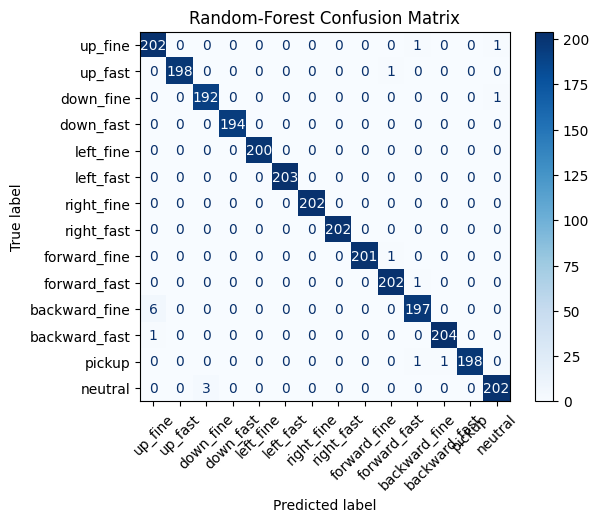


Top-10 landmark features:
  landmark  8 y:  0.0724
  landmark 12 y:  0.0630
  landmark 16 y:  0.0610
  landmark  0 y:  0.0556
  landmark 20 y:  0.0505
  landmark 11 y:  0.0399
  landmark  7 y:  0.0395
  landmark 19 y:  0.0387
  landmark 16 x:  0.0348
  landmark  8 x:  0.0333

Model saved to: /content/drive/My Drive/model_rf_14classes__20250612__074003__acc_0.994.pkl


In [4]:
import os, joblib, numpy as np, datetime as dt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns

class_names = [
    'up_fine','up_fast','down_fine','down_fast',
    'left_fine','left_fast','right_fine','right_fast',
    'forward_fine','forward_fast','backward_fine','backward_fast',
    'pickup','neutral'
]

# 1. Load & stack
X, y = [], []
for idx, cname in enumerate(class_names):
    arr = np.load(f"/content/data/data_{cname}.npz")
    X.append(arr['X'])
    y.append(arr['y'])
X = np.vstack(X).astype('float32')
y = np.concatenate(y).astype('int32')
print("Total samples:", X.shape)

# 2. Split
Xtr, Xte, ytr, yte = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=1
)

# 3. Grid-search a small RF
param_grid = {
    'n_estimators':[200,300],
    'max_depth':[None,18],
    'min_samples_leaf':[1,2]
}
base = RandomForestClassifier(
    max_features='sqrt',
    random_state=1,
    n_jobs=-1
)
search = GridSearchCV(base, param_grid, cv=3, n_jobs=-1, verbose=1)
search.fit(Xtr, ytr)
rf = search.best_estimator_
print("Best params:", search.best_params_)

# 4. Evaluate
yhat = rf.predict(Xte)
acc  = accuracy_score(yte, yhat)
print(f"\nTest accuracy: {acc:.3f}")

# Confusion matrix
plt.figure(figsize=(8,8))
ConfusionMatrixDisplay.from_predictions(
    yte, yhat, display_labels=class_names, xticks_rotation=45, cmap='Blues'
)
plt.title("Random-Forest Confusion Matrix"); plt.show()

# Top 10 feature importances
imp = rf.feature_importances_
top = np.argsort(imp)[-10:][::-1]
print("\nTop-10 landmark features:")
for i in top:
    lm = i//2; axis = 'x' if i%2==0 else 'y'
    print(f"  landmark {lm:2d} {axis}:  {imp[i]:.4f}")

# 5. Save model back to Drive
stamp = dt.datetime.now().strftime("%Y%m%d__%H%M%S")
MODEL_PATH = f"/content/drive/My Drive/model_rf_14classes__{stamp}__acc_{acc:.3f}.pkl"
joblib.dump(rf, MODEL_PATH)
print("\nModel saved to:", MODEL_PATH)


In [5]:
from google.colab import files
files.download(MODEL_PATH)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>